In [55]:
import scipy.io
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)

- Time-courses for 7 different fMRI tasks (n_regions, n_timecourses, n_subjects)
- 379 brain regions, x timecourses, 100 subjects
- Easy task = Motor
- Task_Paradigms contains, for each subject, the exact temporal details on the presentation of the task.

_"For instance, the task can have 2 or more conditions, then you will have a block regressor with values going from 0 (no presentation) to the number of conditions. This signal, after being separated into the different conditions and convolved with the hemodynamic response function HRF,  is normally used in the general linear model to assess which voxels activate together with a specific condition. I can give you more details about that during the meeting."_ - Giulia

In [149]:
# loading the fMRI data and one regressor for a MOTOR task
mat = scipy.io.loadmat('./Data/X_tfMRI_MOTOR_LR_Glasser360.mat')
mat_r = scipy.io.loadmat('./Data/TaskParadigms/100307_Regressor_tfMRI_MOTOR_LR.mat')
mat_hrf = scipy.io.loadmat('./Data/hrf.mat')

In [155]:
mat_swap = np.swapaxes(mat['X'], 2, 0)

In [179]:
mat_swap.shape

(100, 284, 379)

In [180]:
mat['X'].shape

(379, 284, 100)

In [193]:
mat['X'][0,:,0]

array([ 0.80710496,  0.02871021,  1.42279732,  1.3818122 , -0.38490265,
       -1.82917802, -1.60147959, -1.29059083, -2.8828249 , -1.85811446,
       -1.27413345, -1.35872717, -1.050732  , -0.24574437, -0.26037345,
        0.35138678,  1.33098669,  1.32635169, -0.24624972,  0.91829376,
        0.6987303 ,  0.14187761, -0.47664639, -0.38849364, -0.9728077 ,
       -1.21227225,  0.30487334,  0.12134862,  0.02411975,  0.57582831,
        1.09015989,  0.14933774,  0.10302709, -0.64509457, -0.64754829,
       -0.56769835, -0.23419528, -0.1440639 ,  1.76722877,  2.07593173,
        1.08298471,  0.4582732 ,  0.09382032, -0.63792596,  0.88360668,
        0.46895404, -0.31916154, -1.36457434,  0.14749381,  0.51172611,
       -0.50275197, -1.57115218, -1.11749489,  0.09654663, -0.42954319,
       -0.10832427, -1.14262376, -0.14363136,  1.07187902,  1.30925672,
        0.78625817,  0.49605979, -0.28897744,  0.26879276, -0.84092953,
       -0.01099614,  0.78795659, -0.05435288,  0.63216106, -1.09

In [163]:
# put it into a dataframe to use pandas
m, n, r = mat['X'].shape
fMRI_arr = np.column_stack((np.repeat(np.arange(r),n),mat_swap.reshape(-1, mat_swap.shape[-1])))
fMRI_df = pd.DataFrame(fMRI_arr)
fMRI_df.rename(columns={fMRI_df.columns[0]: "subject" }, inplace=True)

In [192]:
fMRI_df[0:10]

,subject,1,2,3,4,5,6,7,8,9,...,370,371,372,373,374,375,376,377,378,379
0,0.0,0.807105,-0.469944,0.255960,0.901189,0.655219,0.190049,1.962332,1.012026,0.189477,...,0.804319,1.746649,1.221657,0.825554,2.747288,-0.969505,-0.843796,1.179021,1.338642,-0.533748
1,0.0,0.028710,-1.156086,0.334619,0.657000,-0.339497,0.041223,0.024062,0.605663,-0.465560,...,0.068394,-0.480765,0.448699,1.780092,0.555378,0.518578,-0.754814,0.005372,0.119521,-0.411905
2,0.0,1.422797,0.586408,0.787939,0.543208,1.105213,1.412824,-0.069503,-0.968812,-0.755039,...,0.101899,0.813609,0.731518,0.092218,1.438177,-1.320536,1.724987,-0.382838,0.339302,-0.766615
3,0.0,1.381812,0.112876,0.040436,0.889510,2.234704,1.777191,1.044210,-0.284701,-0.281078,...,1.555901,1.413162,-0.290591,2.235404,1.497536,-0.193758,0.788103,-0.436544,1.040516,0.605673
4,0.0,-0.384903,-2.292528,0.225186,-0.587886,-0.395003,0.535247,-0.061782,-1.151337,-0.923558,...,-1.906484,0.855558,0.454855,0.303957,-0.029345,-0.167311,-0.147738,-1.247765,-0.227408,-0.477118
5,0.0,-1.829178,-0.134154,-0.341849,-1.335813,-0.036363,1.392400,0.575322,-0.153894,-1.423415,...,-1.487387,-0.869412,-0.427388,0.996226,0.654037,-0.601423,-0.696618,-1.363524,-0.319632,-0.631556
6,0.0,-1.601480,-0.073889,-0.743807,-1.843728,-1.397714,0.647900,0.080028,-0.573169,0.845577,...,-0.317511,0.357172,0.930101,1.436441,1.182670,0.583949,-1.498763,-1.674117,-0.496911,-0.684840
7,0.0,-1.290591,-0.677583,0.461357,-0.324009,-0.088280,0.753504,0.523809,-0.475005,0.298739,...,-0.633350,-1.241455,0.595971,0.354317,0.931008,0.319585,0.861594,0.728591,0.025661,0.249881
8,0.0,-2.882825,0.357089,0.105501,-2.060085,-1.720933,0.218931,-0.073174,-0.458635,0.118975,...,-1.628469,-1.383068,-0.433292,-0.020693,0.367916,0.393391,-0.069571,-0.989038,-0.183225,-0.015542
9,0.0,-1.858114,-0.725702,-0.339957,-1.701816,-0.831504,1.006856,0.116724,0.108315,-0.209871,...,-0.843169,-0.987259,0.570927,1.423897,0.613912,-0.646657,-0.134669,-2.129105,-1.675874,-0.781384


In [165]:
# mangling the hrf
hrf = mat_hrf['hrf'].squeeze()
pad = np.zeros(10, dtype=hrf.dtype)
hrf = np.concatenate((pad, hrf, pad))

## Structure of fMRI_df

- Column 0 indicates the subject, i.e. `fMRI_df['subject']==0` selects the fMRI data of one subject
- Column 1 - 379 indicate the fMRI data for the 379 regions

## Fitting the GLM

Now we want to fit a GLM for one subject and one region. To do this, we execute the following steps:
- get a regressor (subject and regressor have to match)
- one-hot encode the regressor function
- convolve the HRF and regressors
- build the GLM
- check the p-value for the regressor parameters

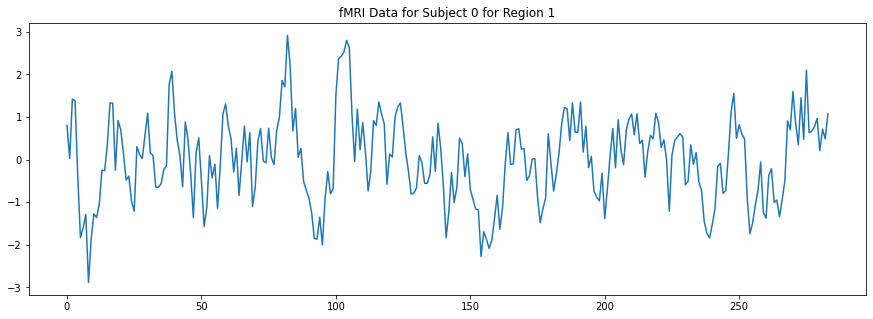

In [166]:
# plotting the fMRI data for subject 0 for region 1
fMRI_df[fMRI_df['subject']==0].iloc[:,1].plot()
plt.title("fMRI Data for Subject 0 for Region 1")
plt.show()

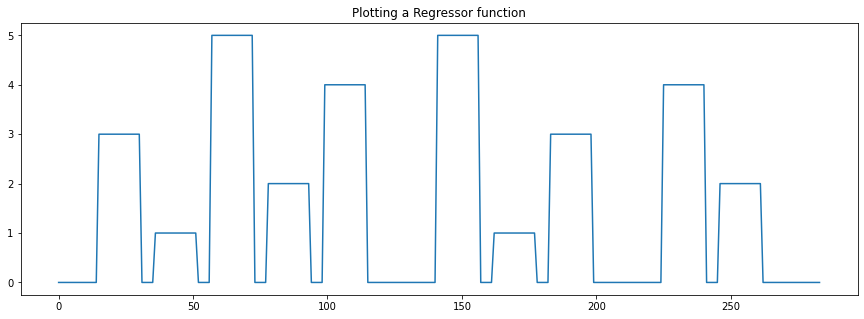

In [167]:
# plotting the regressor
plt.plot(np.arange(0,284,1),mat_r['Regressor'].T)
plt.title("Plotting a Regressor function")
plt.show()

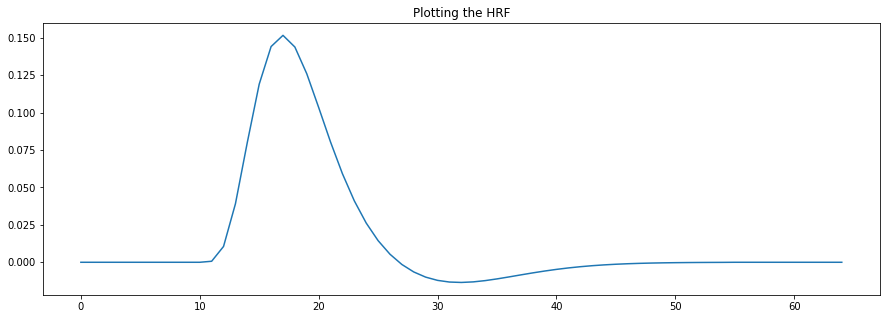

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.78030213e-04,
        1.05610475e-02,  3.90365341e-02,  8.00705224e-02,  1.18940164e-01,
        1.44055594e-01,  1.51536354e-01,  1.43743327e-01,  1.25909187e-01,
        1.03401506e-01,  8.03144564e-02,  5.91378907e-02,  4.10156987e-02,
        2.61970392e-02,  1.44532864e-02,  5.37224432e-03, -1.47564068e-03,
       -6.46758900e-03, -9.91635549e-03, -1.20836316e-02, -1.31983996e-02,
       -1.34701860e-02, -1.30945875e-02, -1.22525424e-02, -1.11062948e-02,
       -9.79484787e-03, -8.43079802e-03, -7.09940444e-03, -5.85991141e-03,
       -4.74862728e-03, -3.78305490e-03, -2.96638195e-03, -2.29178112e-03,
       -1.74615867e-03, -1.31317048e-03, -9.75468991e-04, -7.16241577e-04,
       -5.20154695e-04, -3.73837871e-04, -2.66037511e-04, -1.87553278e-04,
       -1.31046745e-04, -

In [168]:
# plotting the HRF
# plotting the regressor
plt.plot(hrf)
plt.title("Plotting the HRF")
plt.show()
hrf

Need to one hot encode the task paradigm data and tie that to the time 
Same model for all voxels but different parameter values
Regression is ordinary least squares -> just use statsmodel?
Try linear combinations of parameters
t = effect size / uncertanty of size
Get data - get model - get weights - get error - contrast - effect size - uncertanty
Hypothesis Test : H0 = No expression
    - Use student t-distribution

Next analyze over the group vs just one subject

Other things to try:
-Smoothing / wavelets
-generalized linear models (non-gaussian densities)
**-non parametric tests**

Popular to do independent component analysis


Note:
General Linear Model Assumptions
Assumptions
fixed impulse response
however, inter-subject variability [Aguirre et al., 1998]
stationarity
space
all brain regions respond the same way
however, intra-subject variability [Schacter et al., 1997]
time
all responses are the same
however, effects from habituation, anticipation, and “background” state
superposition
response to separate events simply sum up
however, in practice non-linear effects (saturation) and interaction


Refinements:

Eliminate low-frequency components
due to
aliased cardiac and respiratory cycle
scanner drift
low-frequency regressors
discrete cosine transform basis set
acts as a high-pass filter
hidden in SPM’s design matrix!
Add motion parameters as regressors
Go beyond “white noise” assumption
SPM: auto-regressive model order 1, AR(1)

In [169]:
# building a dataframe with the regressors
regressors_df = pd.DataFrame(mat_r['Regressor'])
regressors_df = regressors_df.transpose()

In [170]:
# one-hot encoding the regressors
regressors_df_sep = pd.get_dummies(regressors_df[0])
# dropping column 0 as to not have a overdetemined model (dummy variable trap)
regressors_df_sep.drop(columns=[0], inplace=True)
regressors_df_sep.head(5)

,1,2,3,4,5
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [171]:
fMRI_df[fMRI_df['subject']==0].iloc[:,1]

0      0.807105
1      0.028710
2      1.422797
3      1.381812
4     -0.384903
         ...   
279    0.968127
280    0.211219
281    0.717473
282    0.488327
283    1.073439
Name: 1, Length: 284, dtype: float64

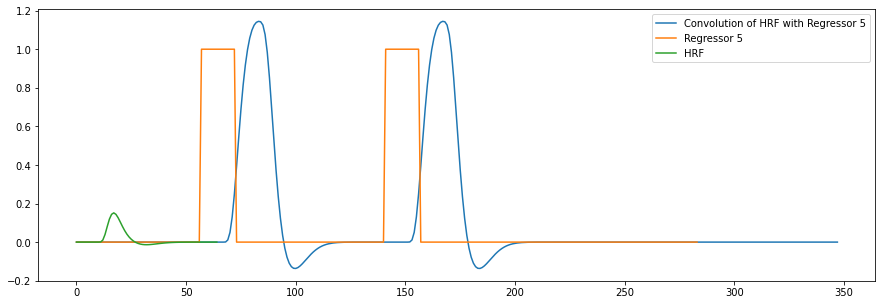

In [172]:
# testing the convolution for one regressor (regressor 5) for subject 0 region 1
subject_0_df = fMRI_df[fMRI_df['subject']==0].iloc[:,1].reset_index(drop=True)
test_conv = scipy.signal.convolve(regressors_df_sep[5], hrf, 'full')
plt.plot(test_conv, label='Convolution of HRF with Regressor 5')
plt.plot(regressors_df_sep[5], label='Regressor 5')
plt.plot(hrf, label='HRF')
plt.legend()
plt.show()

In [174]:
# doing the convolutions for all regressors for subject 0, region 1
regressors_df_sep_conv = regressors_df_sep.apply(lambda x: np.convolve(x, hrf, 'full')[:x.shape[0]])
regressors_df_sep_conv.head()

,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [175]:
# fitting a GLM to region 1 of subject 0
X = sm.add_constant(regressors_df_sep_conv)
y = subject_0_df.reset_index(drop=True)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      1   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     10.52
Date:                Wed, 11 Nov 2020   Prob (F-statistic):           2.91e-09
Time:                        14:58:05   Log-Likelihood:                -377.87
No. Observations:                 284   AIC:                             767.7
Df Residuals:                     278   BIC:                             789.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4923      0.092     -5.354      0.0

## Hypothesis Testing

p-value(5) < 0.05, we can reject H0 for region 1, subject 1 and regressor 5, i.e. regressor 5 has a siginifant beta value.